In the below python code, we have joined 3 datasets: 2 of them - cust_demograhics.csv and claims.csv are downloaded from internet and third dataset "American_States.csv" has been created by us to perform exploratory data analysis

In [126]:
import numpy as np
import pandas as pd

In [127]:
#existing datasets
customers = pd.read_csv('../data/cust_demographics.csv')
claims = pd.read_csv('../data/claims.csv')

#New dataset created for mapping us state abbreviation to state names and state region and subregion
united_states_and_regions = pd.read_csv('../data/American_States.csv')

In [128]:
customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver
3,47830476,Female,01-May-86,MA,413-187-7945,Silver
4,19269962,Male,13-May-77,NV,956-871-8691,Gold


In [129]:
claims.head()

,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,$2980,1,No
1,33985796,75740424,Crime,10/03/2018,Home,Unknown,Material only,$2980,3,No
2,53522022,30308357,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1,Yes
3,13015401,47830476,Natural causes,06/17/2018,Auto,No,Material only,$1680,1,No
4,22890252,19269962,Crime,01/13/2018,Auto,No,Material only,$2680,1,No


In [130]:
united_states_and_regions.head()

,State,StateName,Region,SubRegion
0,AK,Alaska,West,Pacific
1,AL,Alabama,South,East South Central
2,AR,Arkansas,South,West South Central
3,AS,American Samoa,No Region,No Region
4,AZ,Arizona,West,Mountain


In [131]:
#Mapping month name to number
month_map = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [132]:
# function to calculate age
from datetime import date

def calculate_age(birth):
    birthdate = int(birth.split('-')[0])
    birthmonth = int(month_map.get(birth.split('-')[1]))
    birthyear =  int(birth.split('-')[2])
    today = date.today() 
    if birthyear > today.year%100:
        birthyear = birthyear + 1900
    else:
        birthyear = birthyear + 2000
    
    born = date(birthyear,birthmonth,birthdate)
    try:  
        birthday = born.replace(year = today.year) 
   
    except ValueError:  
        birthday = born.replace(year = today.year, 
                  month = born.month + 1, day = 1) 
  
    if birthday > today: 
        return today.year - born.year - 1
    else: 
        return today.year - born.year 

In [133]:
customers['customer_age'] = customers['DateOfBirth'].apply(calculate_age)
customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,49
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35
3,47830476,Female,01-May-86,MA,413-187-7945,Silver,33
4,19269962,Male,13-May-77,NV,956-871-8691,Gold,42


In [134]:
#Joining the datasets to get perform EDA on the resulting dataset
# first join - customers,claims

claims_per_customers = pd.merge(customers,claims,left_on = 'CUST_ID', right_on = 'customer_id')

In [135]:
del claims_per_customers['customer_id']

In [136]:
claims_per_customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40,54004764,Driver error,11/27/2017,Auto,No,Material only,$2980,1,No
1,75740424,Female,13-Jan-70,ME,265-543-1264,Silver,49,33985796,Crime,10/03/2018,Home,Unknown,Material only,$2980,3,No
2,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,53522022,Other driver error,02/02/2018,Auto,No,Material only,$3369.5,1,Yes
3,30308357,Female,11-Mar-84,TN,798-631-4758,Silver,35,63017412,Driver error,04/04/2018,Auto,No,Material only,$1950,6,No
4,47830476,Female,01-May-86,MA,413-187-7945,Silver,33,13015401,Natural causes,06/17/2018,Auto,No,Material only,$1680,1,No


In [137]:
claims_per_customers = pd.merge(claims_per_customers,united_states_and_regions)
claims_per_customers.head()

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,customer_age,claim_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,StateName,Region,SubRegion
0,21868593,Female,12-Jan-79,VT,789-916-8172,Platinum,40,54004764,Driver error,11/27/2017,Auto,No,Material only,$2980,1,No,Vermont,NorthEast,New England
1,16868327,Male,14-Feb-68,VT,426-293-4958,Silver,51,3883874,Driver error,01/14/2017,Auto,No,Material only,$1400,1,No,Vermont,NorthEast,New England
2,20960664,Female,28-Oct-87,VT,276-719-1489,Platinum,31,18499217,Natural causes,08/10/2018,Auto,Yes,Injury only,$19676.5,1,Yes,Vermont,NorthEast,New England
3,68615086,Male,12-Nov-80,VT,326-937-6952,Platinum,38,66563034,Driver error,07/07/2018,Auto,No,Material and injury,$17670,1,No,Vermont,NorthEast,New England
4,49078798,Male,07-May-65,VT,168-931-2841,Gold,54,69278867,Natural causes,02/02/2018,Auto,No,Material only,$1350,1,No,Vermont,NorthEast,New England


In [138]:
claims_per_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 19 columns):
CUST_ID                1085 non-null int64
gender                 1085 non-null object
DateOfBirth            1085 non-null object
State                  1085 non-null object
Contact                1085 non-null object
Segment                1085 non-null object
customer_age           1085 non-null int64
claim_id               1085 non-null int64
incident_cause         1085 non-null object
claim_date             1085 non-null object
claim_area             1085 non-null object
police_report          1085 non-null object
claim_type             1085 non-null object
claim_amount           1082 non-null object
total_policy_claims    1085 non-null int64
fraudulent             1085 non-null object
StateName              1085 non-null object
Region                 1085 non-null object
SubRegion              1085 non-null object
dtypes: int64(4), object(15)
memory usage: 169.5+ KB


In [159]:
# creating pivot table to retrieve the average claim amount per subregion per gender

claims_subregion_gender = claims_per_customers.pivot_table(index = 'SubRegion', columns = 'gender', values = 'claim_amount',aggfunc = 'mean')
claims_subregion_gender

gender,Female,Male
SubRegion,,
East North Central,12909.776786,12278.640000
East South Central,8074.372340,12118.102564
Mid-Atlantic,11445.151515,11458.583333
Mountain,15065.455696,12902.306818
New England,11212.580882,14739.220779
Pacific,13258.158537,14713.467391
South Atlantic,13218.391566,11471.105556
West North Central,11150.422078,12189.437500
West South Central,10542.697674,10777.816327


In [139]:
#segregate population into different categories based on age 
def population_category(age):
    if age < 18:
        return 'Children'
    elif age < 30:
        return 'Youth'
    elif age < 60:
        return 'Adult'
    else:
        return 'Senior'

In [140]:
claims_per_customers['population_category'] = claims_per_customers['customer_age'].apply(population_category)

In [141]:
claims_per_customers['claim_amount'] = claims_per_customers['claim_amount'].replace('[\$,]', '', regex=True).astype(float)

In [142]:
avg_claim_per_segment = claims_per_customers.groupby('Segment',as_index = False).agg({'claim_amount':'mean'})
avg_claim_per_segment

,Segment,claim_amount
0,Gold,12731.532086
1,Platinum,12367.009722
2,Silver,11935.429598


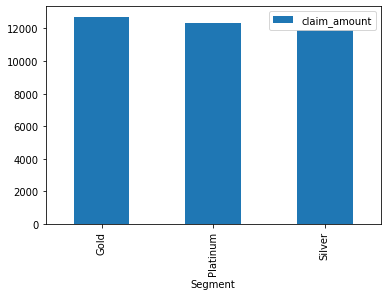

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting barchart to understand the claim amounts across segments
avg_claim_per_segment.plot.bar(x = 'Segment',y='claim_amount');

It is clear from the above plot that claim amounts vary slightly with different segments

In [144]:
# number of adults from AK,DE,TX who have driver related incident claims
import seaborn as sns

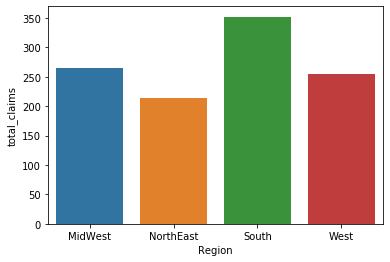

In [145]:
claims_per_region = claims_per_customers.groupby('Region').size().reset_index()
claims_per_region.rename(columns = {0:'total_claims'}, inplace = True)
sns.barplot(x = 'Region', y = 'total_claims', data = claims_per_region);

It can be seen from the above graph that most number of claims come from the South region in US

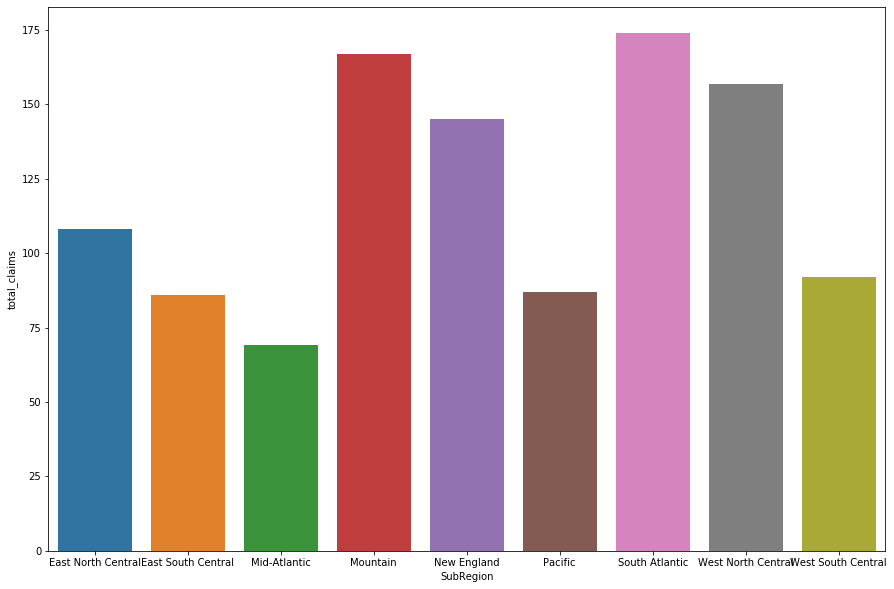

In [146]:
fig, ax = plt.subplots(1,1,figsize = (15,10))
claims_per_region = claims_per_customers.groupby('SubRegion').size().reset_index()
claims_per_region.rename(columns = {0:'total_claims'}, inplace = True)
sns.barplot(x = 'SubRegion', y = 'total_claims', data = claims_per_region);

It can be inferred from the above barchart that maximum claims came from South Atlantic subregion, followed by Mountain,West North Central and New England subregions 

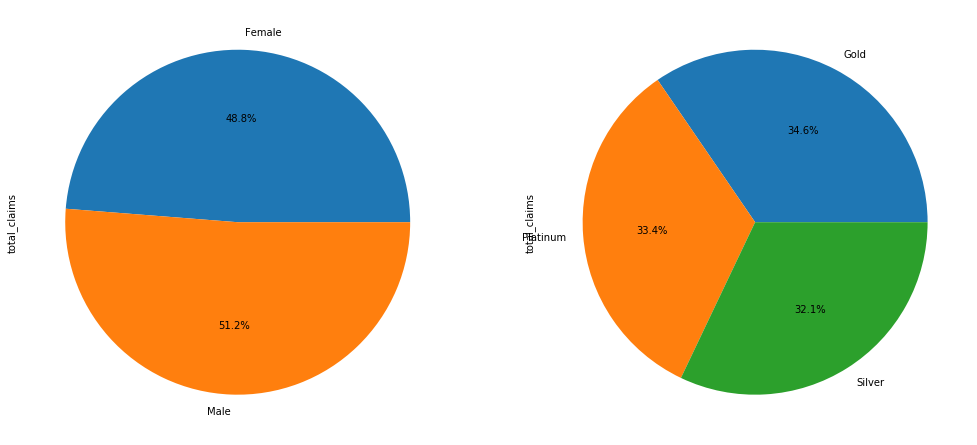

In [147]:
# use pie chart to represent percentage of claims by gender and segment
claims_per_gender = pd.DataFrame(claims_per_customers.groupby(['gender'],as_index=False).size().reset_index())
claims_per_gender.rename(columns = {0:'total_claims'}, inplace = True)
claims_per_segment = pd.DataFrame(claims_per_customers.groupby(['Segment'],as_index=False).size().reset_index())
claims_per_segment.rename(columns = {0:'total_claims'}, inplace = True)

fig1, ax = plt.subplots(nrows=1,ncols=2,figsize = (17,10))
claims_per_gender.plot(kind='pie', y = 'total_claims', autopct='%1.1f%%',ax= ax[0], 
labels=claims_per_gender['gender'],  legend = False, fontsize=10);
claims_per_segment.plot(kind='pie', y = 'total_claims', autopct='%1.1f%%', ax = ax[1],
labels=claims_per_segment['Segment'],  legend = False, fontsize=10);

1. It can be inferred from the first piechart that the claims made by males are a little higher than those by females
2. The second piechart shows that most claims come from customers in the Gold Segment

,population_category,non_fraud_claims
0,Adult,614
1,Youth,224


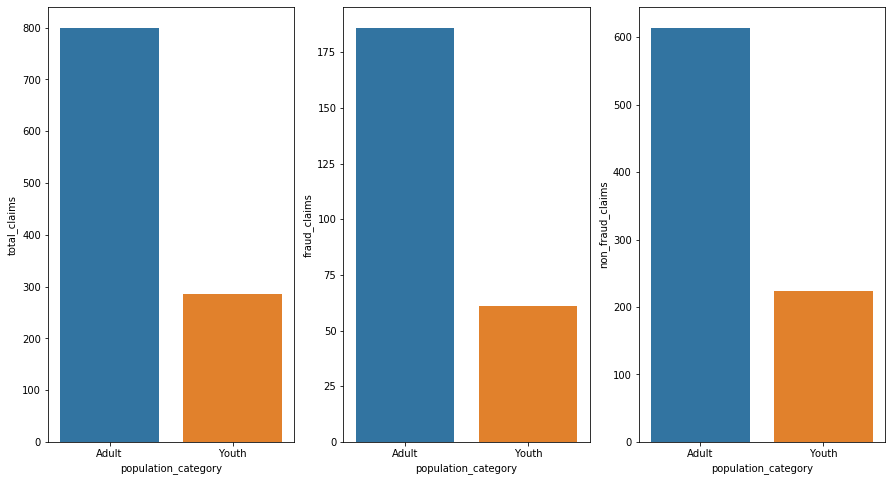

In [148]:
#most fraudulent policy claims
import seaborn as sns
#plt.figure(17,10)
fig , ax = plt.subplots(1,3,figsize=(15,8))

# #total claims
total_claims = claims_per_customers.groupby(['population_category']).size().reset_index(name='total_claims')
sns.barplot(x = 'population_category', y ='total_claims', data = total_claims , ax= ax[0]);
total_claims

# Fraudulent claims
fraudulent_claims = claims_per_customers[claims_per_customers['fraudulent']=='Yes']
fraudulent_claims = fraudulent_claims.groupby(['population_category']).size().reset_index(name='fraud_claims')
sns.barplot(x = 'population_category', y ='fraud_claims', data = fraudulent_claims, ax=ax[1]);

# Non-Fraudulent claims
non_fraudulent_claims = claims_per_customers[claims_per_customers['fraudulent']=='No']
non_fraudulent_claims = non_fraudulent_claims.groupby(['population_category']).size().reset_index(name='non_fraud_claims')
sns.barplot(x = 'population_category', y ='non_fraud_claims', data = non_fraudulent_claims, ax=ax[2]);
non_fraudulent_claims

We are comparing the fraudulent claims per category of population and conclude that the ratio of fraudulent to total claims is similar for the Adult and Youth categories

In [162]:
#claims_per_customers['claim_month'] = int(month_map.get(claims_per_customers['claim_date'].split('-')[1]))
claims_per_customers['claim_month'] = claims_per_customers['claim_date'].apply(lambda x: x.split('/')[0])
claims_per_customers['claim_year'] = claims_per_customers['claim_date'].apply(lambda x: x.split('/')[2])

In [152]:
claims_2017 = claims_per_customers[claims_per_customers['claim_year']=='2017']
claim_by_period = claims_2017.groupby(['claim_month','claim_year'],as_index=False).agg({'claim_amount':'sum'})[['claim_month','claim_year','claim_amount']]
claim_by_period

,claim_month,claim_year,claim_amount
0,01,2017,608157.5
1,02,2017,613168.0
2,03,2017,612153.0
3,04,2017,763154.0
4,05,2017,535879.0
5,06,2017,563942.0
6,07,2017,799776.5
7,08,2017,424113.0
8,09,2017,416137.0
9,10,2017,635490.5


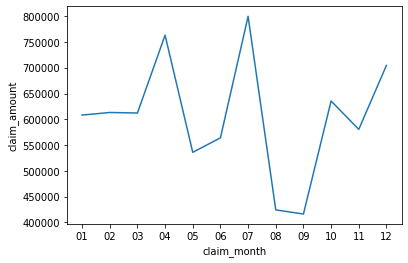

In [161]:
sns.lineplot(x='claim_month', y= 'claim_amount', data =claim_by_period);

Two interesting observations emerge from the above linechart
1. Most claims are made in the months of April and July as maximum claim amounts can be seen in these periods
2. Very few claims are made in the months of August and September described the low claim amounts for these months